In [1]:
# --- Load all the required libraries ---

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

In [3]:
# --- 1. LOAD THE PREPARED DATASET ---

print("--> Loading the prepared HDFS feature matrix...")
try:
    df = pd.read_parquet("D:/IoC-Free IDS using ML and NLP/data/processed/hdfs_v1_feature_matrix_labeled.parquet")
    print("Dataset loaded successfully!")
except FileNotFoundError:
    print("Error: 'hdfs_v1_feature_matrix_labeled.parquet' not found.")
    print("Please make sure you have run the data cleaning notebook first.")
    exit()

--> Loading the prepared HDFS feature matrix...
Dataset loaded successfully!


In [4]:
# --- 2. PREPARE DATA FOR MODELING ---

print("\n--> Preparing data for the model...")

# Labels are already binary: 0 for Normal (Success), 1 for Anomaly (Fail)

X = df.drop('label', axis = 1)
y = df['label']


# Split data into training and testing sets

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.3, random_state = 8, stratify = y
)

# IMPORTANT: For anomaly detection, we train the model ONLY on normal data.
# This teaches the model what "normal" behavior looks like.

print(f"Filtering training data to include only normal samples...")
X_train_normal = X_train[y_train == 0]
print(f"Original training set size: {len(X_train)}")
print(f"New training set size (normal data only): {len(X_train_normal)}")


--> Preparing data for the model...
Filtering training data to include only normal samples...
Original training set size: 402542
New training set size (normal data only): 390755


In [5]:
# --- 3. TRAIN THE ISOLATION FOREST MODEL ---

print("\n--> Training the Isolation Forest model...")

# contamination = the expected proportion of anomalies in the dataset.
# This is a key parameter to tune. Let's start with a guess based on the data.

anomaly_proportion = len(y[y == 1]) / len(y)
iso_forest = IsolationForest(contamination = anomaly_proportion, random_state = 8, n_jobs = -1)
iso_forest.fit(X_train_normal)
print("Model training complete.")


--> Training the Isolation Forest model...
Model training complete.


In [6]:
# --- 4. EVALUATE THE MODEL ON THE FULL TEST SET ---

print("\n--> Evaluating the model on the full test set (includes anomalies)...")

# The model predicts -1 for anomalies and 1 for normal instances.
# We need to map these predictions to our label format (1 for anomaly, 0 for normal).

predictions = iso_forest.predict(X_test)
y_pred = [1 if p == -1 else 0 for p in predictions]

# Print evaluation metrics

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}")
print("\nClassification Report (0 = Normal, 1 = Anomaly):")
print(classification_report(y_test, y_pred, digits = 4))


--> Evaluating the model on the full test set (includes anomalies)...

Accuracy: 0.9456

Classification Report (0 = Normal, 1 = Anomaly):
              precision    recall  f1-score   support

           0     0.9729    0.9710    0.9720    167468
           1     0.0979    0.1043    0.1010      5051

    accuracy                         0.9456    172519
   macro avg     0.5354    0.5377    0.5365    172519
weighted avg     0.9473    0.9456    0.9465    172519




--> Generating confusion matrix...
Confusion matrix saved to 'log_confusion_matrix.png'


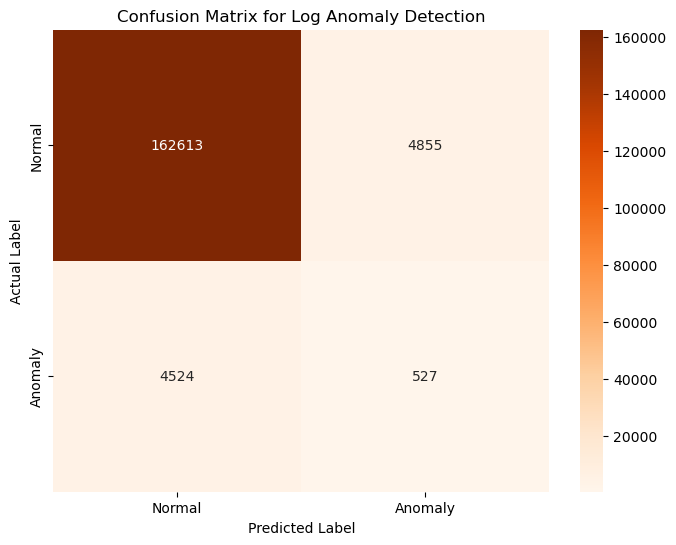

In [8]:
# --- 5. VISUALIZE THE CONFUSION MATRIX ---

print("\n--> Generating confusion matrix...")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Oranges', xticklabels = ['Normal', 'Anomaly'], yticklabels = ['Normal', 'Anomaly'])
plt.title('Confusion Matrix for Log Anomaly Detection')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.savefig('D:/IoC-Free IDS using ML and NLP/results/log_confusion_matrix.png')
print("Confusion matrix saved to 'log_confusion_matrix.png'")
plt.show()

In [9]:
# --- 6. SAVE THE TRAINED MODEL ---

print("\n--> Saving the trained model...")
joblib.dump(iso_forest, 'D:/IoC-Free IDS using ML and NLP/initial_models/isolation_forest_log_model.joblib')
print("✅ Model saved successfully!")


--> Saving the trained model...
✅ Model saved successfully!
